In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
import timm

class ResNet50V2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50V2Classifier, self).__init__()
        # Load pretrained ResNet50V2 model using timm.
        self.model = timm.create_model('resnetv2_50', pretrained=True)
        # Replace the classifier head with a new one for your task.
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        # Extract features using forward_features.
        x = self.model.forward_features(x)  # shape: (batch, channels, H, W)
        # Apply adaptive average pooling to get shape (batch, channels, 1, 1)
        if x.ndim == 4:
            x = F.adaptive_avg_pool2d(x, (1, 1))
        # Flatten the tensor for the classifier head.
        x = torch.flatten(x, 1)  # shape: (batch, channels)
        # Pass through the modified classifier head.
        x = self.model.head(x)
        return x


In [7]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [8]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [10]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [11]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [12]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=74d52c4be65a6ae0951bb1ea489f503833053eddf530e77de3559f18ee284ec5
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=9d166fcc4f20dedef2b57c13f32f376ed4f3d44905b0737e04f4dae8caee4c3d
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = ResNet50V2Classifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 23.5M                |
|  module                |  23.5M               |
|   module.model         |   23.5M              |
|    module.model.stem   |    9.4K              |
|    module.model.stages |    23.5M             |
|    module.model.norm   |    4.1K              |
|    module.model.head   |    6.1K              |
Total FLOPs: 4.13 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.3677, Accuracy: 0.6515, Precision: 0.5143, Recall: 0.6515, F1 Score: 0.5565


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 5.59 sec, Peak GPU Memory: 1298.10 MB
Validation Loss: 0.3520, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3209, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.50 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.3316, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2834, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.48 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.3200, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2581, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.43 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.3115, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2432, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.3081, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2305, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.56 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2959, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2196, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.54 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2958, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2102, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.50 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2944, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2026, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.53 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2862, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1949, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.45 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2866, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1901, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.54 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2848, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1824, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2843, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1783, Accuracy: 0.6860, Precision: 0.4706, Recall: 0.6860, F1 Score: 0.5582


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.75 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2814, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1741, Accuracy: 0.6865, Precision: 0.5646, Recall: 0.6865, F1 Score: 0.5596


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1395.21 MB
Validation Loss: 0.2756, Accuracy: 0.6567, Precision: 0.6247, Recall: 0.6567, F1 Score: 0.5223
Best model updated based on validation accuracy
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1708, Accuracy: 0.6905, Precision: 0.6031, Recall: 0.6905, F1 Score: 0.5691


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1392.09 MB
Validation Loss: 0.2730, Accuracy: 0.6633, Precision: 0.5959, Recall: 0.6633, F1 Score: 0.5375
Best model updated based on validation accuracy
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1662, Accuracy: 0.6950, Precision: 0.5936, Recall: 0.6950, F1 Score: 0.5798


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.30 sec, Peak GPU Memory: 1392.37 MB
Validation Loss: 0.2771, Accuracy: 0.6600, Precision: 0.6262, Recall: 0.6600, F1 Score: 0.5298
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1653, Accuracy: 0.7005, Precision: 0.6158, Recall: 0.7005, F1 Score: 0.5911


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1392.37 MB
Validation Loss: 0.2715, Accuracy: 0.6633, Precision: 0.5800, Recall: 0.6633, F1 Score: 0.5401
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1634, Accuracy: 0.7040, Precision: 0.5958, Recall: 0.7040, F1 Score: 0.5995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1392.37 MB
Validation Loss: 0.2691, Accuracy: 0.6717, Precision: 0.5914, Recall: 0.6717, F1 Score: 0.5573
Best model updated based on validation accuracy
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1604, Accuracy: 0.7100, Precision: 0.6081, Recall: 0.7100, F1 Score: 0.6115


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.55 sec, Peak GPU Memory: 1390.49 MB
Validation Loss: 0.2661, Accuracy: 0.6700, Precision: 0.5615, Recall: 0.6700, F1 Score: 0.5549
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1580, Accuracy: 0.7245, Precision: 0.6253, Recall: 0.7245, F1 Score: 0.6368


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1390.49 MB
Validation Loss: 0.2642, Accuracy: 0.6767, Precision: 0.5760, Recall: 0.6767, F1 Score: 0.5696
Best model updated based on validation accuracy
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1570, Accuracy: 0.7265, Precision: 0.6190, Recall: 0.7265, F1 Score: 0.6412


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1391.71 MB
Validation Loss: 0.2650, Accuracy: 0.6750, Precision: 0.5584, Recall: 0.6750, F1 Score: 0.5673
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1550, Accuracy: 0.7335, Precision: 0.6225, Recall: 0.7335, F1 Score: 0.6526


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.61 sec, Peak GPU Memory: 1391.71 MB
Validation Loss: 0.2613, Accuracy: 0.6850, Precision: 0.5746, Recall: 0.6850, F1 Score: 0.5868
Best model updated based on validation accuracy
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1542, Accuracy: 0.7345, Precision: 0.6236, Recall: 0.7345, F1 Score: 0.6545


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1391.41 MB
Validation Loss: 0.2605, Accuracy: 0.6817, Precision: 0.5696, Recall: 0.6817, F1 Score: 0.5794
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1525, Accuracy: 0.7385, Precision: 0.6256, Recall: 0.7385, F1 Score: 0.6607


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1391.41 MB
Validation Loss: 0.2586, Accuracy: 0.6883, Precision: 0.5864, Recall: 0.6883, F1 Score: 0.5920
Best model updated based on validation accuracy
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1518, Accuracy: 0.7510, Precision: 0.6432, Recall: 0.7510, F1 Score: 0.6783


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.61 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2603, Accuracy: 0.6850, Precision: 0.5763, Recall: 0.6850, F1 Score: 0.5882
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1513, Accuracy: 0.7505, Precision: 0.6445, Recall: 0.7505, F1 Score: 0.6774


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.55 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2588, Accuracy: 0.6867, Precision: 0.5714, Recall: 0.6867, F1 Score: 0.5915
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1497, Accuracy: 0.7480, Precision: 0.6370, Recall: 0.7480, F1 Score: 0.6749


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2589, Accuracy: 0.6817, Precision: 0.5649, Recall: 0.6817, F1 Score: 0.5830
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1491, Accuracy: 0.7565, Precision: 0.6479, Recall: 0.7565, F1 Score: 0.6864


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2576, Accuracy: 0.6833, Precision: 0.5716, Recall: 0.6833, F1 Score: 0.5840
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1483, Accuracy: 0.7550, Precision: 0.6458, Recall: 0.7550, F1 Score: 0.6841


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.46 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2571, Accuracy: 0.6850, Precision: 0.5718, Recall: 0.6850, F1 Score: 0.5870
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1470, Accuracy: 0.7570, Precision: 0.6474, Recall: 0.7570, F1 Score: 0.6870


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.63 sec, Peak GPU Memory: 1391.67 MB
Validation Loss: 0.2563, Accuracy: 0.6800, Precision: 0.5758, Recall: 0.6800, F1 Score: 0.5776
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

Test Inference Time: 2.57 sec, Peak GPU Memory: 1482.95 MB
Test Loss: 0.2506, Accuracy: 0.6883, Precision: 0.5864, Recall: 0.6883, F1 Score: 0.5920
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.70      0.20      0.31       117
           1       0.69      0.99      0.81       393
           2       0.00      0.00      0.00        90

    accuracy                           0.69       600
   macro avg       0.46      0.40      0.37       600
weighted avg       0.59      0.69      0.59       600



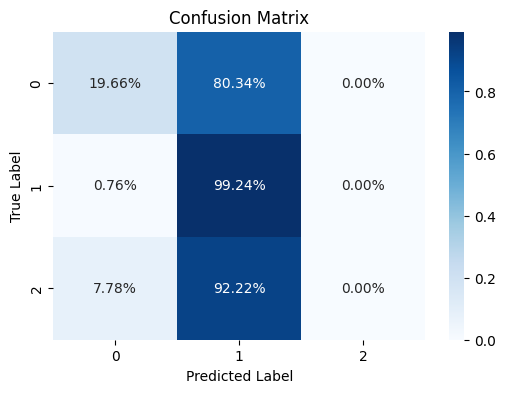

Test Sensitivity: 0.9924, Test Specificity: 0.1966


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


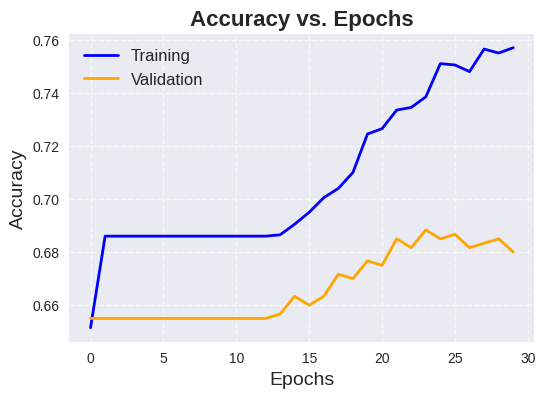

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


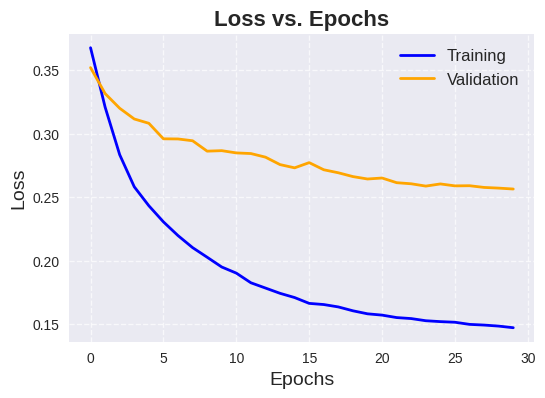

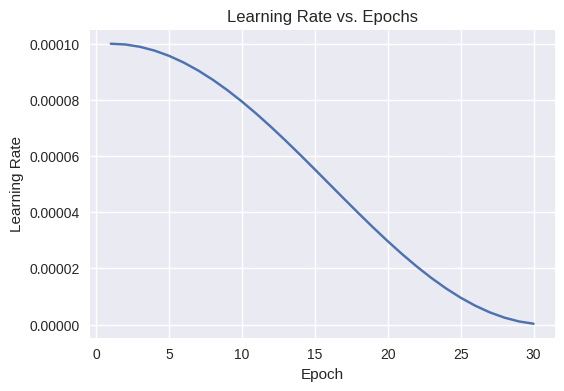

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1498, Accuracy: 0.7595, Precision: 0.6517, Recall: 0.7595, F1 Score: 0.6903


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2490, Accuracy: 0.6867, Precision: 0.5631, Recall: 0.6867, F1 Score: 0.6006
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1441, Accuracy: 0.7880, Precision: 0.6793, Recall: 0.7880, F1 Score: 0.7270


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.61 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2505, Accuracy: 0.6783, Precision: 0.5475, Recall: 0.6783, F1 Score: 0.5975
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1405, Accuracy: 0.8160, Precision: 0.7109, Recall: 0.8160, F1 Score: 0.7598


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2532, Accuracy: 0.6883, Precision: 0.5642, Recall: 0.6883, F1 Score: 0.6142
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1355, Accuracy: 0.8360, Precision: 0.7380, Recall: 0.8360, F1 Score: 0.7831


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2479, Accuracy: 0.6800, Precision: 0.5602, Recall: 0.6800, F1 Score: 0.6110
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1310, Accuracy: 0.8490, Precision: 0.7566, Recall: 0.8490, F1 Score: 0.7977


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.50 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2500, Accuracy: 0.6633, Precision: 0.5582, Recall: 0.6633, F1 Score: 0.6061
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1254, Accuracy: 0.8600, Precision: 0.7750, Recall: 0.8600, F1 Score: 0.8106


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2433, Accuracy: 0.6633, Precision: 0.5787, Recall: 0.6633, F1 Score: 0.6172
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1205, Accuracy: 0.8625, Precision: 0.7808, Recall: 0.8625, F1 Score: 0.8140


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.51 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2421, Accuracy: 0.6733, Precision: 0.5871, Recall: 0.6733, F1 Score: 0.6263
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.1166, Accuracy: 0.8650, Precision: 0.9104, Recall: 0.8650, F1 Score: 0.8172


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.38 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2394, Accuracy: 0.6733, Precision: 0.5953, Recall: 0.6733, F1 Score: 0.6300
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.1112, Accuracy: 0.8690, Precision: 0.9167, Recall: 0.8690, F1 Score: 0.8224


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Validation Inference Time: 2.49 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2465, Accuracy: 0.6500, Precision: 0.7384, Recall: 0.6500, F1 Score: 0.6185
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 0.1057, Accuracy: 0.8760, Precision: 0.9206, Recall: 0.8760, F1 Score: 0.8358


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1483.97 MB
Validation Loss: 0.2382, Accuracy: 0.6567, Precision: 0.7150, Recall: 0.6567, F1 Score: 0.6308
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 45/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Train Loss: 0.0872, Accuracy: 0.9665, Precision: 0.9691, Recall: 0.9665, F1 Score: 0.9656


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.66 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2407, Accuracy: 0.6833, Precision: 0.7057, Recall: 0.6833, F1 Score: 0.6890
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0855, Accuracy: 0.9665, Precision: 0.9670, Recall: 0.9665, F1 Score: 0.9659


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2424, Accuracy: 0.6950, Precision: 0.7229, Recall: 0.6950, F1 Score: 0.7044
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0823, Accuracy: 0.9750, Precision: 0.9755, Recall: 0.9750, F1 Score: 0.9747


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Validation Inference Time: 2.56 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2514, Accuracy: 0.6800, Precision: 0.7035, Recall: 0.6800, F1 Score: 0.6879
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0786, Accuracy: 0.9810, Precision: 0.9812, Recall: 0.9810, F1 Score: 0.9808


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2424, Accuracy: 0.6950, Precision: 0.7031, Recall: 0.6950, F1 Score: 0.6971
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0753, Accuracy: 0.9840, Precision: 0.9839, Recall: 0.9840, F1 Score: 0.9839


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2503, Accuracy: 0.6800, Precision: 0.7105, Recall: 0.6800, F1 Score: 0.6910
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0738, Accuracy: 0.9840, Precision: 0.9839, Recall: 0.9840, F1 Score: 0.9839


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2495, Accuracy: 0.6767, Precision: 0.7039, Recall: 0.6767, F1 Score: 0.6871
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0702, Accuracy: 0.9890, Precision: 0.9889, Recall: 0.9890, F1 Score: 0.9890


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1485.38 MB
Validation Loss: 0.2396, Accuracy: 0.6967, Precision: 0.7026, Recall: 0.6967, F1 Score: 0.6979
Best model updated based on validation accuracy
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0687, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2391, Accuracy: 0.6933, Precision: 0.7133, Recall: 0.6933, F1 Score: 0.7014
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Train Loss: 0.0659, Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Validation Inference Time: 2.53 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2419, Accuracy: 0.6933, Precision: 0.7169, Recall: 0.6933, F1 Score: 0.7024
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0659, Accuracy: 0.9895, Precision: 0.9895, Recall: 0.9895, F1 Score: 0.9895


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2406, Accuracy: 0.6933, Precision: 0.7106, Recall: 0.6933, F1 Score: 0.7004
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0637, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2367, Accuracy: 0.6900, Precision: 0.7058, Recall: 0.6900, F1 Score: 0.6963
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0626, Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2341, Accuracy: 0.6933, Precision: 0.7046, Recall: 0.6933, F1 Score: 0.6981
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0618, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2333, Accuracy: 0.6900, Precision: 0.7027, Recall: 0.6900, F1 Score: 0.6954
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0594, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.71 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2426, Accuracy: 0.6867, Precision: 0.7120, Recall: 0.6867, F1 Score: 0.6965
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0589, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.66 sec, Peak GPU Memory: 1482.40 MB
Validation Loss: 0.2348, Accuracy: 0.6983, Precision: 0.7160, Recall: 0.6983, F1 Score: 0.7053
Best model updated based on validation accuracy
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Train Loss: 0.0581, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1484.36 MB
Validation Loss: 0.2410, Accuracy: 0.6883, Precision: 0.7162, Recall: 0.6883, F1 Score: 0.6988
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0577, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1484.36 MB
Validation Loss: 0.2313, Accuracy: 0.7000, Precision: 0.7206, Recall: 0.7000, F1 Score: 0.7080
Best model updated based on validation accuracy
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Train Loss: 0.0559, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2303, Accuracy: 0.6950, Precision: 0.7205, Recall: 0.6950, F1 Score: 0.7047
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0556, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2303, Accuracy: 0.6950, Precision: 0.7167, Recall: 0.6950, F1 Score: 0.7033
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0555, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2318, Accuracy: 0.6917, Precision: 0.7199, Recall: 0.6917, F1 Score: 0.7023
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0540, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2308, Accuracy: 0.6650, Precision: 0.7011, Recall: 0.6650, F1 Score: 0.6785
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0538, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2228, Accuracy: 0.6933, Precision: 0.7120, Recall: 0.6933, F1 Score: 0.7007
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0539, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2199, Accuracy: 0.6950, Precision: 0.7081, Recall: 0.6950, F1 Score: 0.7004
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0511, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Validation Inference Time: 2.61 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2180, Accuracy: 0.6967, Precision: 0.7060, Recall: 0.6967, F1 Score: 0.7008
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0515, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2270, Accuracy: 0.6817, Precision: 0.7075, Recall: 0.6817, F1 Score: 0.6917
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0502, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1482.12 MB
Validation Loss: 0.2199, Accuracy: 0.6883, Precision: 0.7128, Recall: 0.6883, F1 Score: 0.6977
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Test Inference Time: 2.61 sec, Peak GPU Memory: 1574.12 MB
Test Loss: 0.2167, Accuracy: 0.7000, Precision: 0.7206, Recall: 0.7000, F1 Score: 0.7080
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.43      0.55      0.48       117
           1       0.84      0.78      0.81       393
           2       0.59      0.56      0.57        90

    accuracy                           0.70       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.72      0.70      0.71       600



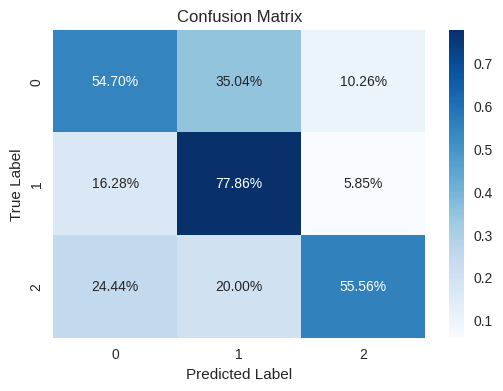

Test Sensitivity: 0.8270, Test Specificity: 0.6095


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


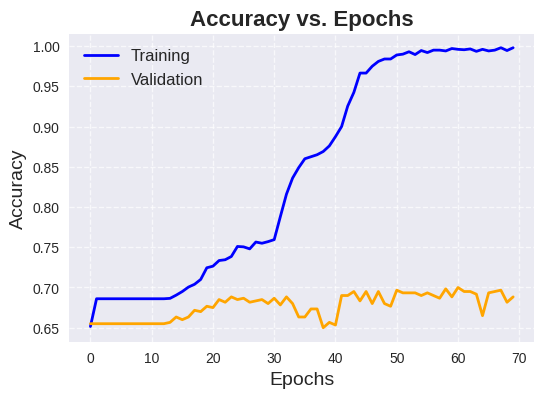

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


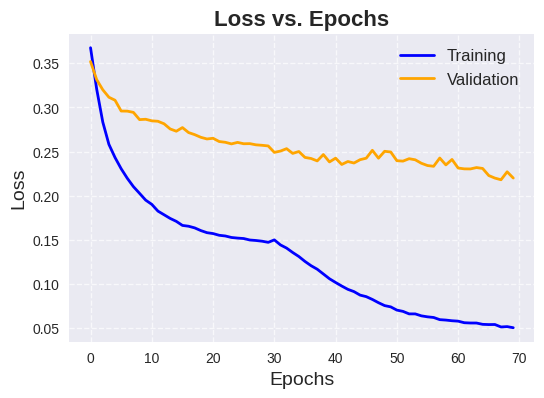

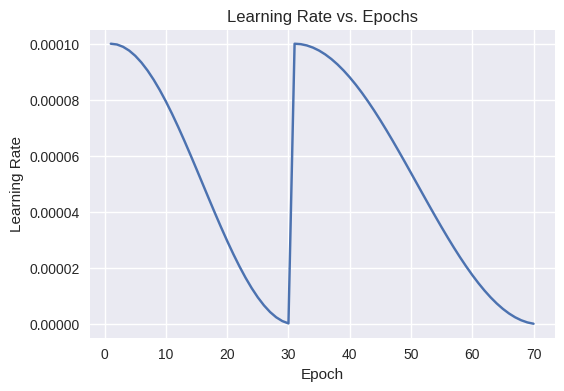

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0500, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1573.12 MB
Validation Loss: 0.2180, Accuracy: 0.7117, Precision: 0.7186, Recall: 0.7117, F1 Score: 0.7147
Best model updated based on validation accuracy
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0495, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2373, Accuracy: 0.6767, Precision: 0.7178, Recall: 0.6767, F1 Score: 0.6913
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Train Loss: 0.0483, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2366, Accuracy: 0.6667, Precision: 0.6880, Recall: 0.6667, F1 Score: 0.6756
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0470, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.68 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2334, Accuracy: 0.6683, Precision: 0.7144, Recall: 0.6683, F1 Score: 0.6844
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0448, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2368, Accuracy: 0.6617, Precision: 0.7136, Recall: 0.6617, F1 Score: 0.6789
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Train Loss: 0.0437, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2176, Accuracy: 0.7033, Precision: 0.7139, Recall: 0.7033, F1 Score: 0.7078
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0430, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2171, Accuracy: 0.6883, Precision: 0.7053, Recall: 0.6883, F1 Score: 0.6953
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0415, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.66 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2193, Accuracy: 0.6833, Precision: 0.7023, Recall: 0.6833, F1 Score: 0.6911
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0403, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.71 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2115, Accuracy: 0.6850, Precision: 0.7050, Recall: 0.6850, F1 Score: 0.6931
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Train Loss: 0.0395, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2250, Accuracy: 0.6717, Precision: 0.7000, Recall: 0.6717, F1 Score: 0.6826
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0392, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2295, Accuracy: 0.6667, Precision: 0.7055, Recall: 0.6667, F1 Score: 0.6806
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0374, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.69 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2236, Accuracy: 0.6767, Precision: 0.7115, Recall: 0.6767, F1 Score: 0.6897
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0372, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2238, Accuracy: 0.6817, Precision: 0.7076, Recall: 0.6817, F1 Score: 0.6917
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0358, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Validation Inference Time: 2.63 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2202, Accuracy: 0.6767, Precision: 0.7069, Recall: 0.6767, F1 Score: 0.6881
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0345, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2073, Accuracy: 0.6950, Precision: 0.7157, Recall: 0.6950, F1 Score: 0.7032
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0341, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Validation Inference Time: 2.58 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2115, Accuracy: 0.6883, Precision: 0.7051, Recall: 0.6883, F1 Score: 0.6953
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0332, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2154, Accuracy: 0.6633, Precision: 0.6944, Recall: 0.6633, F1 Score: 0.6752
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0323, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.69 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2006, Accuracy: 0.7017, Precision: 0.7144, Recall: 0.7017, F1 Score: 0.7072
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Train Loss: 0.0316, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2021, Accuracy: 0.6683, Precision: 0.7058, Recall: 0.6683, F1 Score: 0.6822
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0310, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Validation Inference Time: 2.60 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2076, Accuracy: 0.6967, Precision: 0.7040, Recall: 0.6967, F1 Score: 0.6993
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0298, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.63 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2049, Accuracy: 0.6950, Precision: 0.7105, Recall: 0.6950, F1 Score: 0.7015
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Train Loss: 0.0287, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.66 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2099, Accuracy: 0.6783, Precision: 0.7057, Recall: 0.6783, F1 Score: 0.6886
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0279, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Validation Inference Time: 2.55 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2150, Accuracy: 0.6733, Precision: 0.7147, Recall: 0.6733, F1 Score: 0.6877
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0268, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.69 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2078, Accuracy: 0.6750, Precision: 0.7034, Recall: 0.6750, F1 Score: 0.6856
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0262, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2069, Accuracy: 0.6850, Precision: 0.7185, Recall: 0.6850, F1 Score: 0.6971
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0253, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Validation Inference Time: 2.56 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1974, Accuracy: 0.6833, Precision: 0.6996, Recall: 0.6833, F1 Score: 0.6899
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


Train Loss: 0.0245, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2086, Accuracy: 0.6717, Precision: 0.6995, Recall: 0.6717, F1 Score: 0.6823
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0244, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Validation Inference Time: 2.61 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1958, Accuracy: 0.6950, Precision: 0.7120, Recall: 0.6950, F1 Score: 0.7019
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0227, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Validation Inference Time: 2.54 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2045, Accuracy: 0.6833, Precision: 0.7037, Recall: 0.6833, F1 Score: 0.6916
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0216, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.68 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2012, Accuracy: 0.6817, Precision: 0.6991, Recall: 0.6817, F1 Score: 0.6882
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0217, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.64 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1947, Accuracy: 0.6983, Precision: 0.7060, Recall: 0.6983, F1 Score: 0.7013
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0205, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Validation Inference Time: 2.57 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.2055, Accuracy: 0.6833, Precision: 0.7119, Recall: 0.6833, F1 Score: 0.6941
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0192, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1941, Accuracy: 0.6983, Precision: 0.7111, Recall: 0.6983, F1 Score: 0.7036
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0181, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.66 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1948, Accuracy: 0.6867, Precision: 0.7038, Recall: 0.6867, F1 Score: 0.6939
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0172, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.69 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1942, Accuracy: 0.6900, Precision: 0.7084, Recall: 0.6900, F1 Score: 0.6976
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0163, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1921, Accuracy: 0.6983, Precision: 0.7098, Recall: 0.6983, F1 Score: 0.7032
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0162, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1947, Accuracy: 0.6867, Precision: 0.6993, Recall: 0.6867, F1 Score: 0.6922
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Train Loss: 0.0145, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Validation Inference Time: 2.67 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1959, Accuracy: 0.6883, Precision: 0.7132, Recall: 0.6883, F1 Score: 0.6978
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.0138, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1911, Accuracy: 0.6983, Precision: 0.7063, Recall: 0.6983, F1 Score: 0.7017
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0129, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.71 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1961, Accuracy: 0.6883, Precision: 0.7076, Recall: 0.6883, F1 Score: 0.6959
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Train Loss: 0.0119, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Validation Inference Time: 2.60 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1916, Accuracy: 0.6833, Precision: 0.7000, Recall: 0.6833, F1 Score: 0.6899
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0115, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1907, Accuracy: 0.6867, Precision: 0.7051, Recall: 0.6867, F1 Score: 0.6936
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0101, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation Inference Time: 2.81 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1946, Accuracy: 0.6883, Precision: 0.7059, Recall: 0.6883, F1 Score: 0.6955
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0092, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Validation Inference Time: 2.62 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1901, Accuracy: 0.6933, Precision: 0.7050, Recall: 0.6933, F1 Score: 0.6979
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0085, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Validation Inference Time: 2.65 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1913, Accuracy: 0.6950, Precision: 0.7087, Recall: 0.6950, F1 Score: 0.7009
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0077, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.59 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1902, Accuracy: 0.6900, Precision: 0.7061, Recall: 0.6900, F1 Score: 0.6966
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0064, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Validation Inference Time: 2.52 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1876, Accuracy: 0.6883, Precision: 0.7043, Recall: 0.6883, F1 Score: 0.6951
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0059, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.69 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1901, Accuracy: 0.6950, Precision: 0.7085, Recall: 0.6950, F1 Score: 0.7006
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0049, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Validation Inference Time: 2.70 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1915, Accuracy: 0.6833, Precision: 0.7075, Recall: 0.6833, F1 Score: 0.6925
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Train Loss: 0.0042, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Validation Inference Time: 2.58 sec, Peak GPU Memory: 1573.81 MB
Validation Loss: 0.1885, Accuracy: 0.6900, Precision: 0.7096, Recall: 0.6900, F1 Score: 0.6980
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Test Inference Time: 2.57 sec, Peak GPU Memory: 1664.66 MB
Test Loss: 0.1587, Accuracy: 0.7117, Precision: 0.7186, Recall: 0.7117, F1 Score: 0.7147
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       117
           1       0.83      0.80      0.82       393
           2       0.57      0.56      0.56        90

    accuracy                           0.71       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.72      0.71      0.71       600



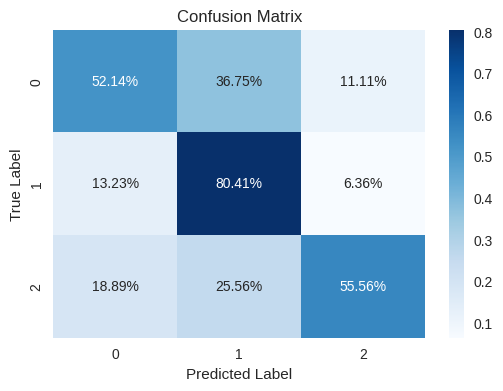

Test Sensitivity: 0.8587, Test Specificity: 0.5865


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


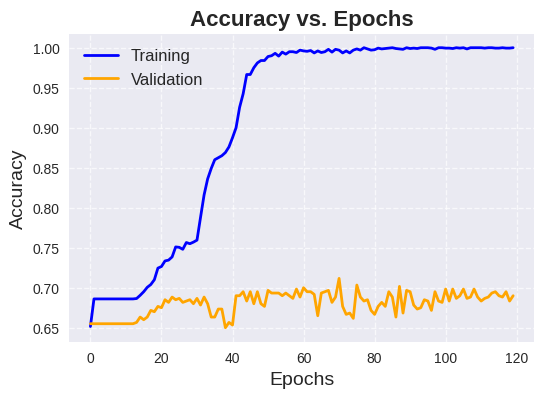

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


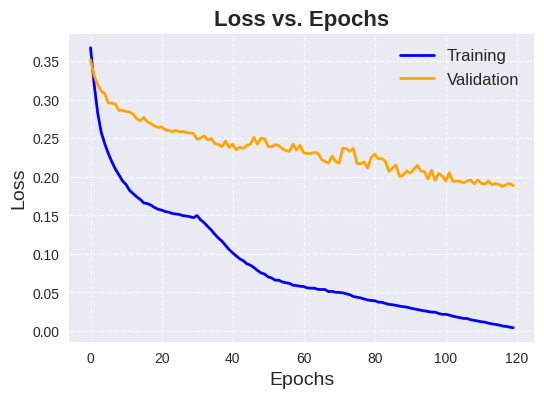

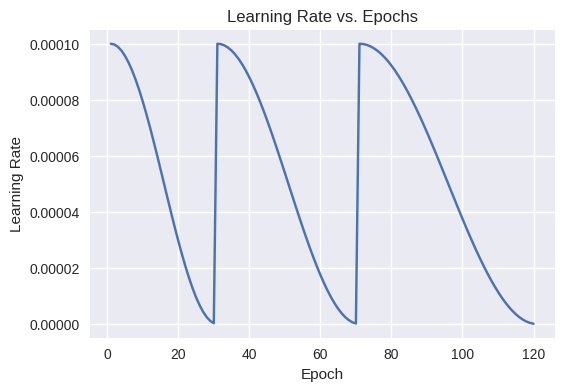

In [14]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)